In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler


df = pd.read_csv("datasets/2022/auto_augment.csv")

# keep rows with valid automation/augmentation scores
df = df.dropna(subset=["aii", "aug"]).copy()

# Choose features (RAW scores here; switch to ["aii_p", "aug_p"] if you want percentiles)
feature_cols = ["aii", "aug"]
X = df[feature_cols].values

# standardize for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# k values to test for all methods
k_values = [2, 3, 4, 5, 6]


In [3]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

gmm_results = []

k_values = [2, 3, 4, 5, 6]

for k in k_values:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type="full",
        random_state=41
    )
    gmm.fit(X_scaled)
    labels = gmm.predict(X_scaled)

    sil = silhouette_score(X_scaled, labels)
    bic = gmm.bic(X_scaled)

    gmm_results.append({
        "k": k,
        "silhouette": sil,
        "bic": bic
    })

gmm_df = pd.DataFrame(gmm_results)
gmm_df




,k,silhouette,bic
0,2,0.194712,69.657635
1,3,0.177994,-193.745693
2,4,0.105189,-245.689024
3,5,0.261665,-1094.122122
4,6,0.204671,-1095.564456


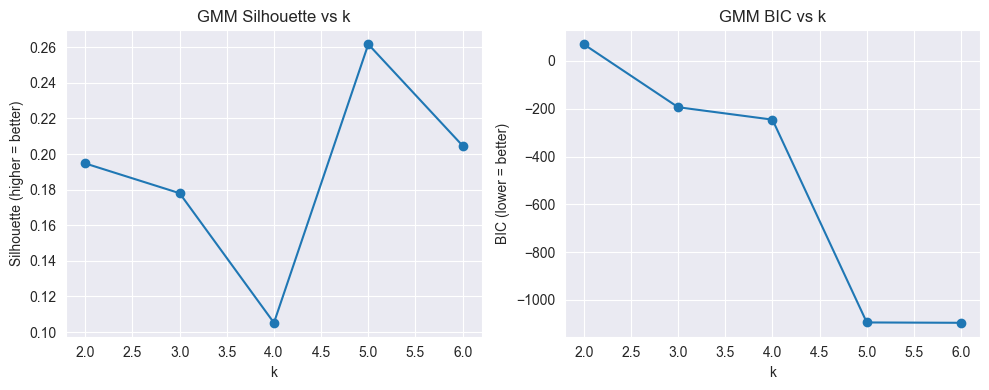

In [4]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(gmm_df["k"], gmm_df["silhouette"], marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette (higher = better)")
plt.title("GMM Silhouette vs k")

plt.subplot(1, 2, 2)
plt.plot(gmm_df["k"], gmm_df["bic"], marker="o")
plt.xlabel("k")
plt.ylabel("BIC (lower = better)")
plt.title("GMM BIC vs k")

plt.tight_layout()
plt.show()


Best GMM k = 5


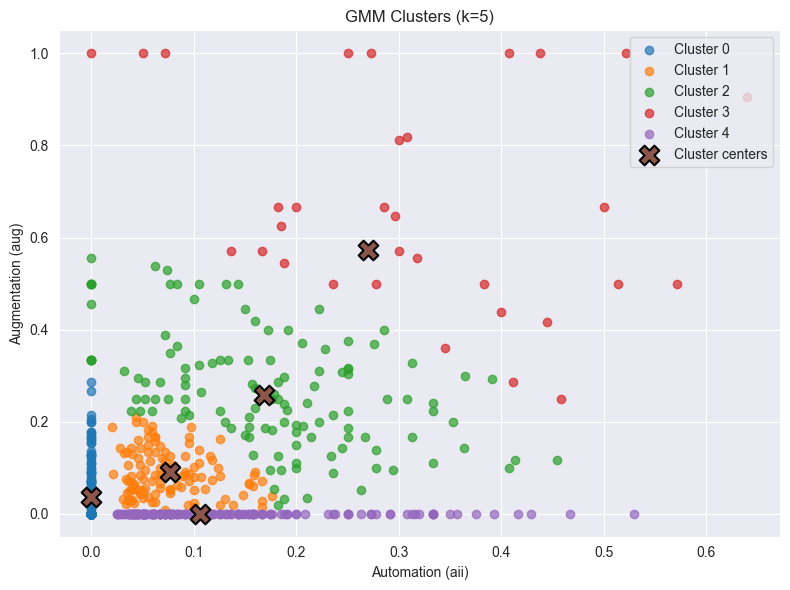

In [5]:
best_k = gmm_df.loc[gmm_df["silhouette"].idxmax(), "k"]
print("Best GMM k =", best_k)

gmm = GaussianMixture(
    n_components=int(best_k),
    covariance_type="full",
    random_state=41
)
gmm.fit(X_scaled)
labels = gmm.predict(X_scaled)
centers = scaler.inverse_transform(gmm.means_)   # convert to original aii/aug space

plt.figure(figsize=(8, 6))
for cid in np.unique(labels):
    plt.scatter(
        df.loc[labels == cid, "aii"],
        df.loc[labels == cid, "aug"],
        label=f"Cluster {cid}",
        alpha=0.7
    )

plt.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="X",
    s=200,
    edgecolor="black",
    linewidth=1.5,
    label="Cluster centers"
)

plt.xlabel("Automation (aii)")
plt.ylabel("Augmentation (aug)")
plt.title(f"GMM Clusters (k={best_k})")
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
from sklearn.cluster import SpectralClustering

spec_results = []

for k in k_values:
    sc = SpectralClustering(
        n_clusters=k,
        affinity='nearest_neighbors',
        random_state=41
    )
    labels = sc.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)

    spec_results.append({
        "k": k,
        "silhouette": sil
    })

spec_df = pd.DataFrame(spec_results)
spec_df


,k,silhouette
0,2,0.110894
1,3,0.174687
2,4,0.206498
3,5,0.261199
4,6,0.248465


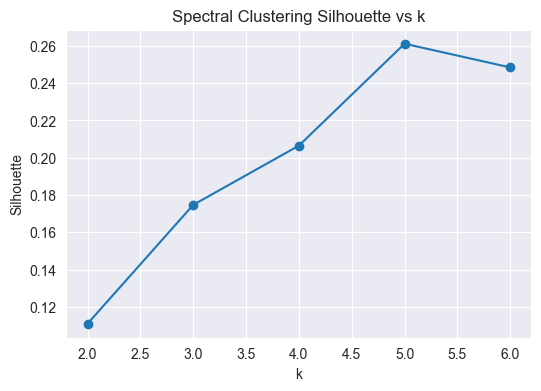

In [7]:
plt.figure(figsize=(6, 4))
plt.plot(spec_df["k"], spec_df["silhouette"], marker="o")
plt.xlabel("k")
plt.ylabel("Silhouette")
plt.title("Spectral Clustering Silhouette vs k")
plt.show()


When comparing GMM / k means, we get different but similar results. Looks like GMM is slightly better

When we look at k means, k means assumes spherical clusters, as it draws equal radius circles around data. The problem is our automation / augmentation data is not spherical and has a heavy skew (low automation but augmentation spreads).

We also have zero inflated values (many jobs at 0 automation / augmentation) which messes up k means. (maybe try a version of k means without these and look at results

This means k means has a hard time representin this shape


When we look at GMM model instead, it shows the true distribution of job exposure

GMM uses probabilistic clusters w/ full covariance matrices (explained there by chatgpt, brush up before full submission)
Clusters can be long, thin, diagonal, and overall more irregular, which allows our graph to be split into more meaningful subtypes.

'GMM creates soft boundaries, which match how ai exposure works in  real life (jobs aren't 'strictly cluster 1 forever - they lie along a spectrum) - chatgpt explanation behind it

GMM clusters match intuition much better than k means,

Cluster  0 - low automation, low augmentation
    Makes sense since many jobs have low ai interaction such as blue collar work

Cluster 1 (orange) - low automation but moderate augmentation
I.e. HR, admin, teachers etc

Cluster 2 (green) - Medium automation, medium augmentation
    Jobs with real ai exposure, but not to extreme values

Cluster 3  (red), high augmentation , moderate high automation
    These are most impacted
    Jobs such as analytical, tech / engineering, and creative works
    These match the parent paper's results


Cluster 4 (purple) - low augmentation, medium automation
    Jobs that arent automatable mechanically, but dont benefit from ai augmentation
    jobs like blue collar, logistics task, repetitive motion tasks etc


Overall we should talk about in our final paper the differences between GMM and K means, why one is better for this specific task, etc